**ОПИСАНИЕ ПРОЕКТА**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Шаг 1. Загрузка данных

In [1]:
# импорты и установки

!pip install phik
!pip install --upgrade scikit-learn

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [2]:
# загрузка файлов с указанием разделителя и десятичного знака

train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', delimiter=',')
test_features = pd.read_csv('/datasets/test_features.csv', delimiter=',')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', delimiter=',')

In [3]:
# выводим первые 5 строк тренировочной выборки, отсортированного по id
train_data = train_data.sort_values(by='id', ascending=False)

train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3757,999521,sales,middle,low,5,yes,no,4,19200,0.87
3909,999348,technology,junior,high,2,no,no,4,46800,0.80
3253,999264,technology,junior,low,2,no,yes,4,22800,0.73
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
3116,998223,purchasing,junior,medium,1,no,no,4,28800,0.60


In [4]:
# выводим первые 5 строк входных признаков тестовой выборки, отсортированного по id

test_features= test_features.sort_values(by='id', ascending=False)

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1844,999029,technology,junior,medium,1,no,no,3,31200
1579,998900,marketing,middle,medium,7,no,no,3,45600
506,998762,technology,junior,low,3,no,no,3,22800
1886,998548,marketing,junior,medium,2,no,no,4,32400
1925,997290,sales,sinior,medium,7,no,no,4,58800


In [5]:
# выводим первые 5 строк целевого признака тестовой выборки, отсортированного по id

test_target = test_target.sort_values(by='id', ascending=False)

test_target.head()

,id,job_satisfaction_rate
334,999029,0.35
931,998900,0.57
780,998762,0.48
1613,998548,0.76
1026,997290,0.79


В первом датасете (train_job_satisfaction_rate.csv) представлены тренировочные данные с целевым признаком. Данные содержат как числовые, так и символьные значения. Данные в двух последних таблицах (test_features.csv, test_target_job_satisfaction_rate) совпадают по ID, но целевой признак выведен в отдельный датасет 

## Шаг 2. Предобработка данных

In [6]:
# смотрим информацию про датасет train_data

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 3757 to 560
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 343.8+ KB


In [7]:
# смотрим количество пропусков

train_data.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [8]:
# Выведем на экран количество строк-дубликатов в train_job_satisfaction_rate

train_data.duplicated().sum()

# Дубликатов не обнаружено

0

In [9]:
# Проверка основных статистик

train_data.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [10]:
# смотрим информацию про датасет test_features

test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1844 to 1172
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


In [11]:
# смотрим количество пропусков

test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [12]:
# Проверка основных статистик

test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [13]:
# смотрим информацию про датасет test_target

test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 334 to 1734
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


In [14]:
# смотрим количество пропусков

test_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

*в тестовой выборке мы ничего менять не можем*

In [15]:
# Проверка основных статистик

test_target.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


# Шаг 3. Исследовательский анализ данных

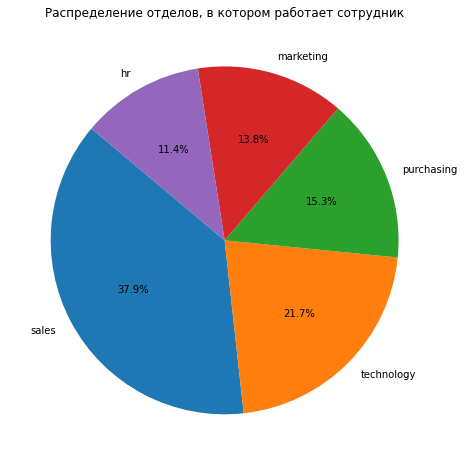

In [16]:
workload_counts = train_data['dept'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(workload_counts, labels=workload_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение отделов, в котором работает сотрудник')
plt.show()

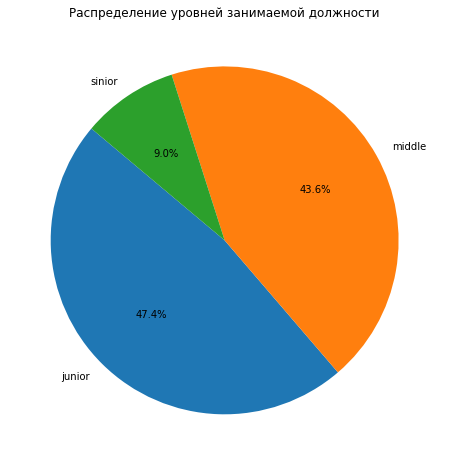

In [17]:
workload_counts = train_data['level'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(workload_counts, labels=workload_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение уровней занимаемой должности')
plt.show()

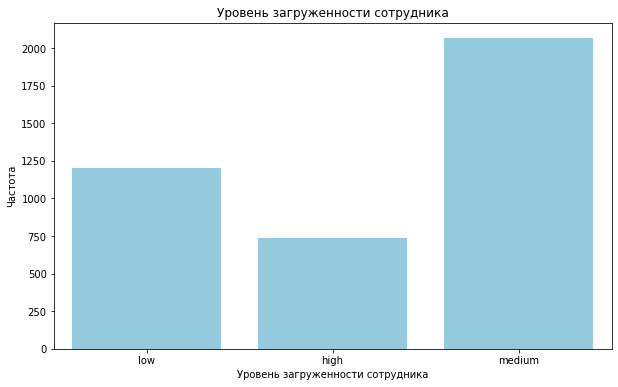

In [18]:
# Построение гистограммы с Seaborn

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='workload', color='skyblue')
plt.title('Уровень загруженности сотрудника')
plt.xlabel('Уровень загруженности сотрудника')
plt.ylabel('Частота')
plt.show()

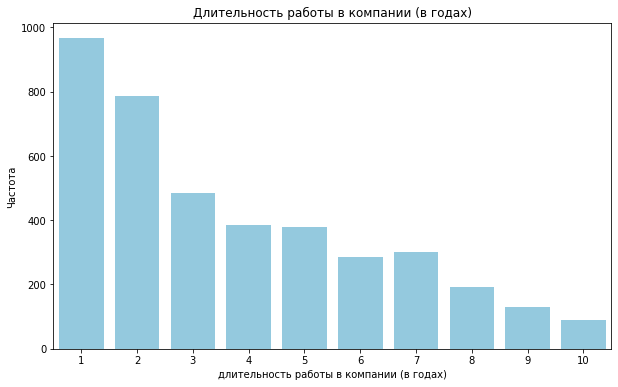

In [19]:
# Построение гистограммы с Seaborn

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='employment_years', color='skyblue')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('длительность работы в компании (в годах)')
plt.ylabel('Частота')
plt.show()

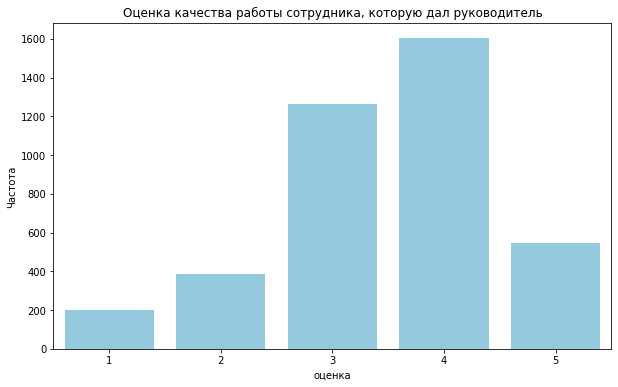

In [20]:
# Построение гистограммы с Seaborn

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='supervisor_evaluation', color='skyblue')
plt.title('Оценка качества работы сотрудника, которую дал руководитель')
plt.xlabel('оценка')
plt.ylabel('Частота')
plt.show()

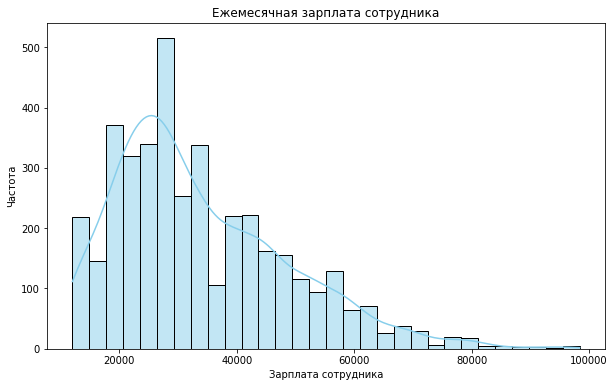

In [21]:
# Построение гистограммы с Seaborn

plt.figure(figsize=(10, 6))
sns.histplot(train_data['salary'], bins=30, kde=True, color='skyblue')  # kde=True добавляет кривую плотности
plt.title('Ежемесячная зарплата сотрудника')
plt.xlabel('Зарплата сотрудника')
plt.ylabel('Частота')
plt.show()

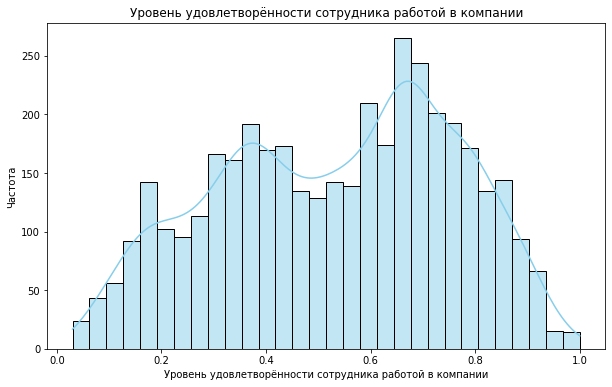

In [22]:
# Построение гистограммы с Seaborn

plt.figure(figsize=(10, 6))
sns.histplot(train_data['job_satisfaction_rate'], bins=30, kde=True, color='skyblue')  # kde=True добавляет кривую плотности
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.xlabel('Уровень удовлетворённости сотрудника работой в компании')
plt.ylabel('Частота')
plt.show()

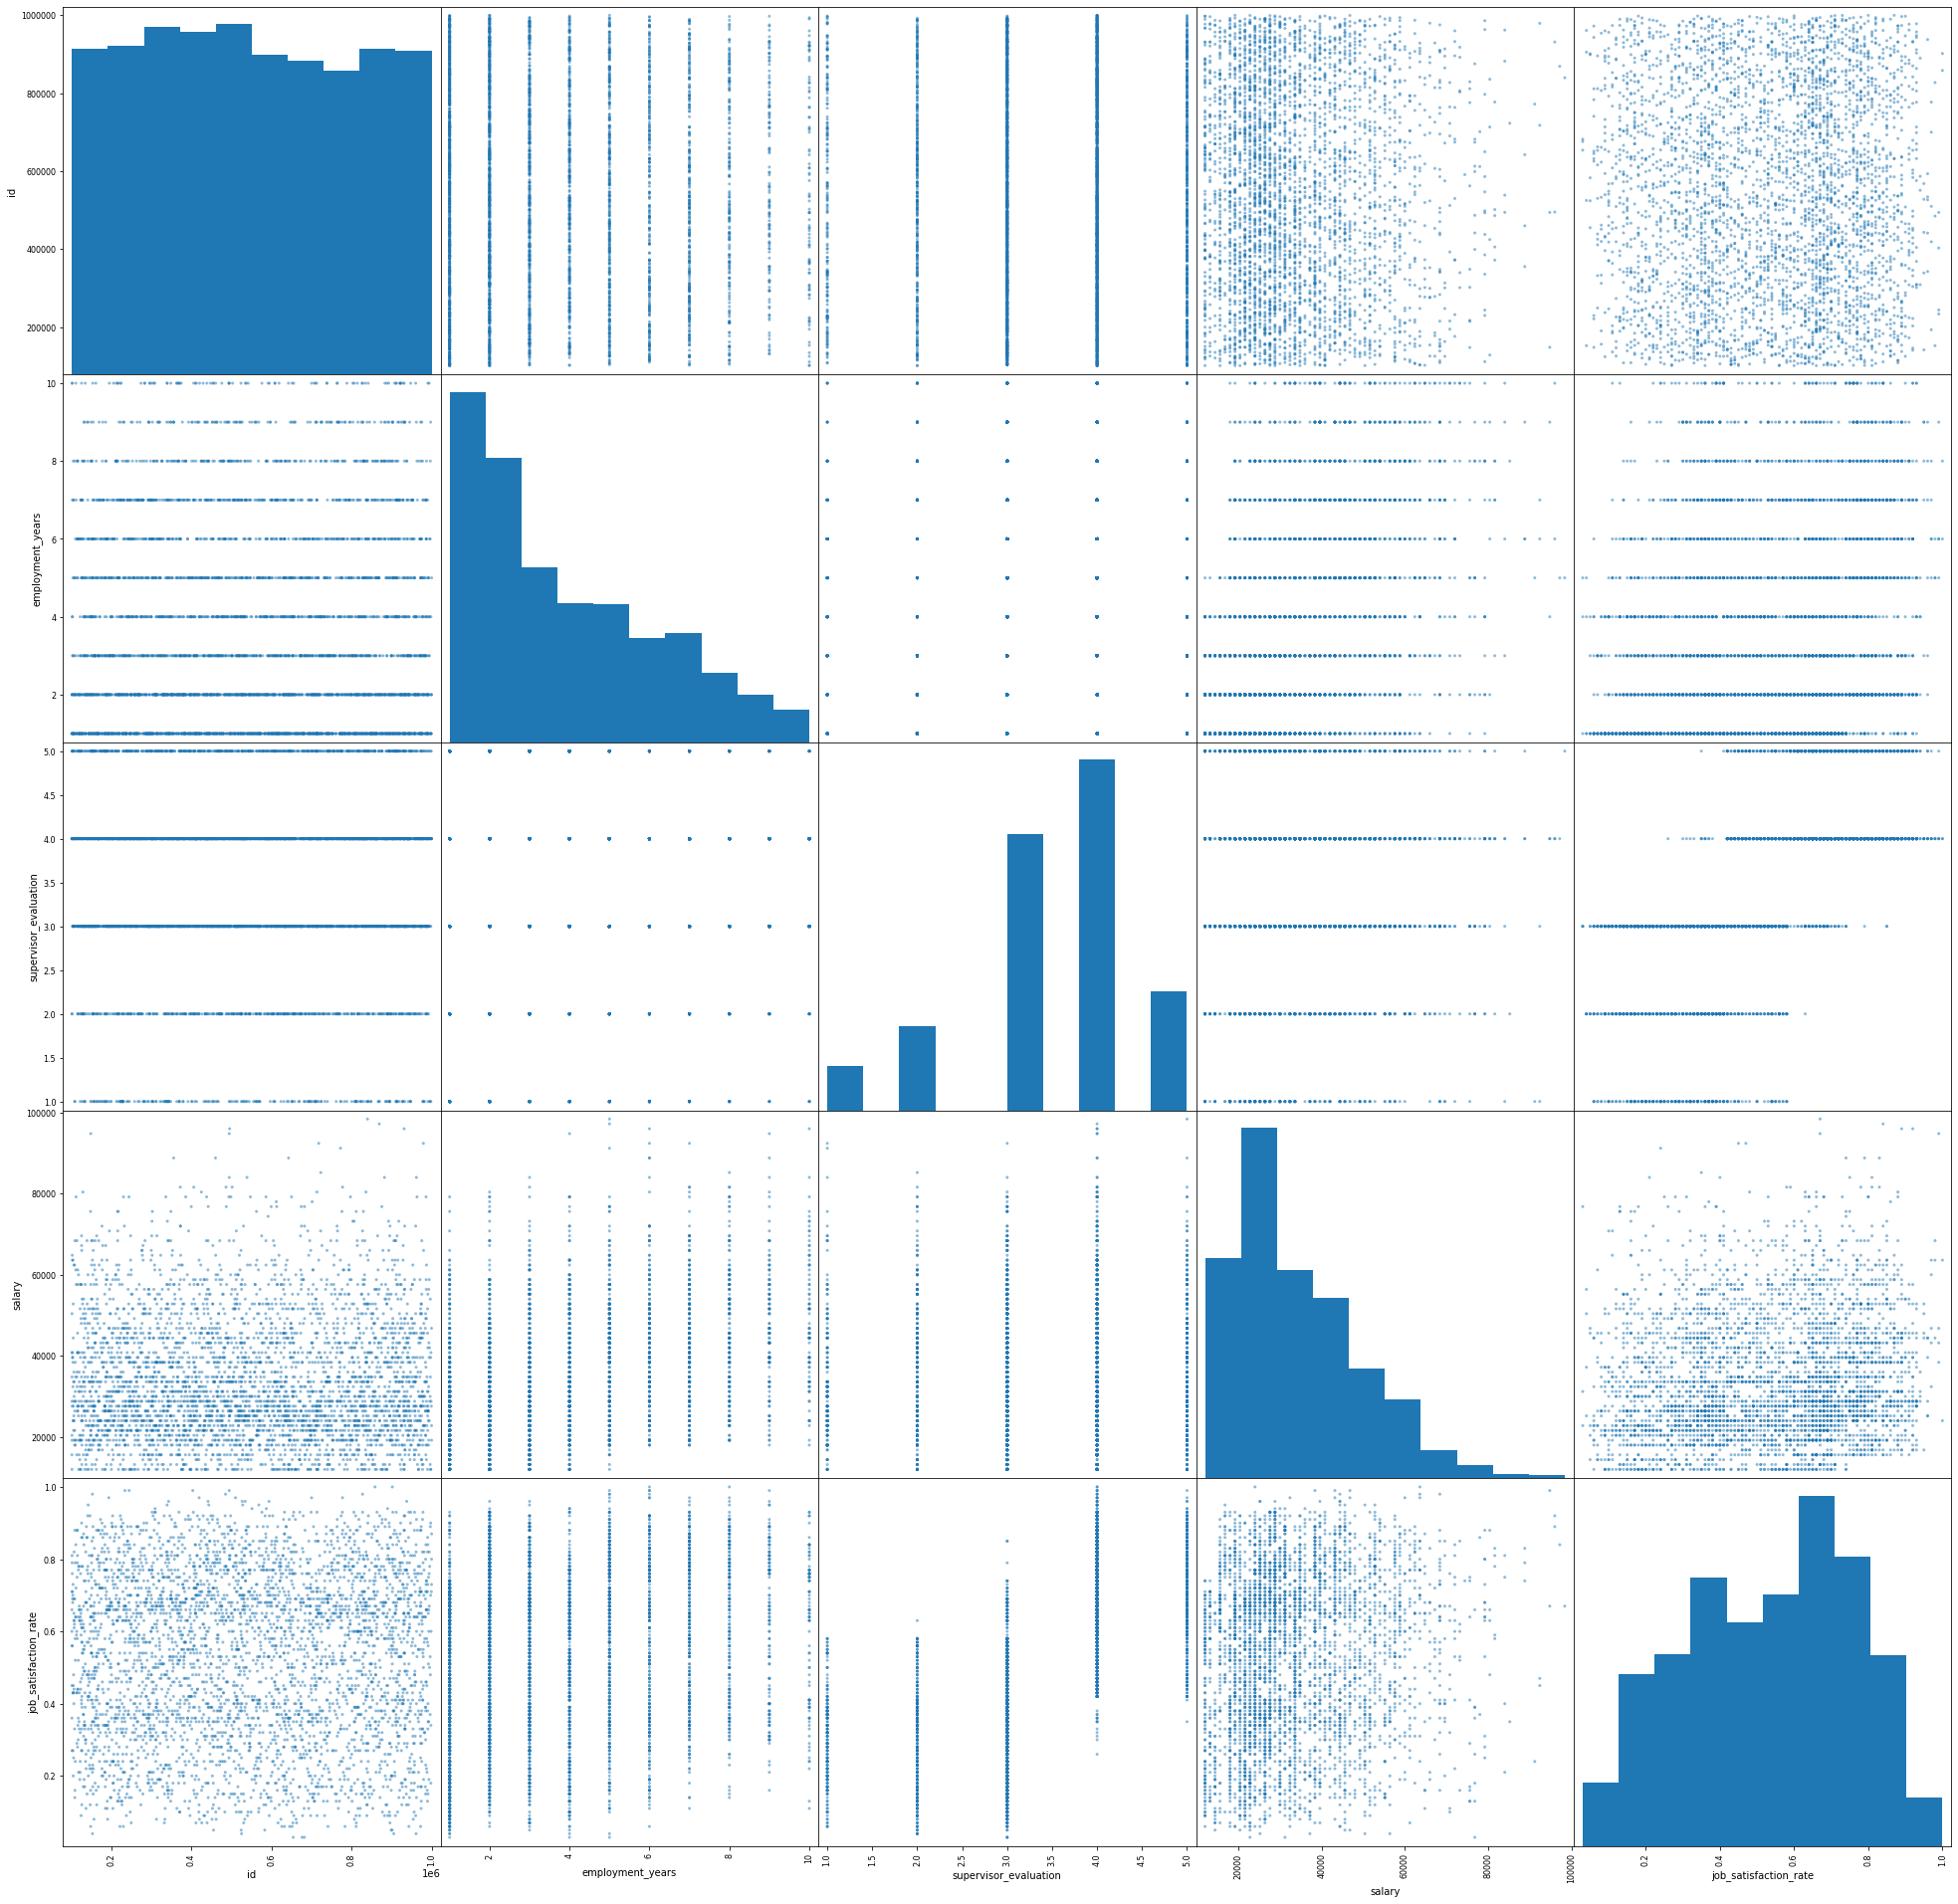

In [23]:
# все диаграммы рассеяния на одном графике

pd.plotting.scatter_matrix(train_data, figsize=(34,34))
plt.show()

In [24]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

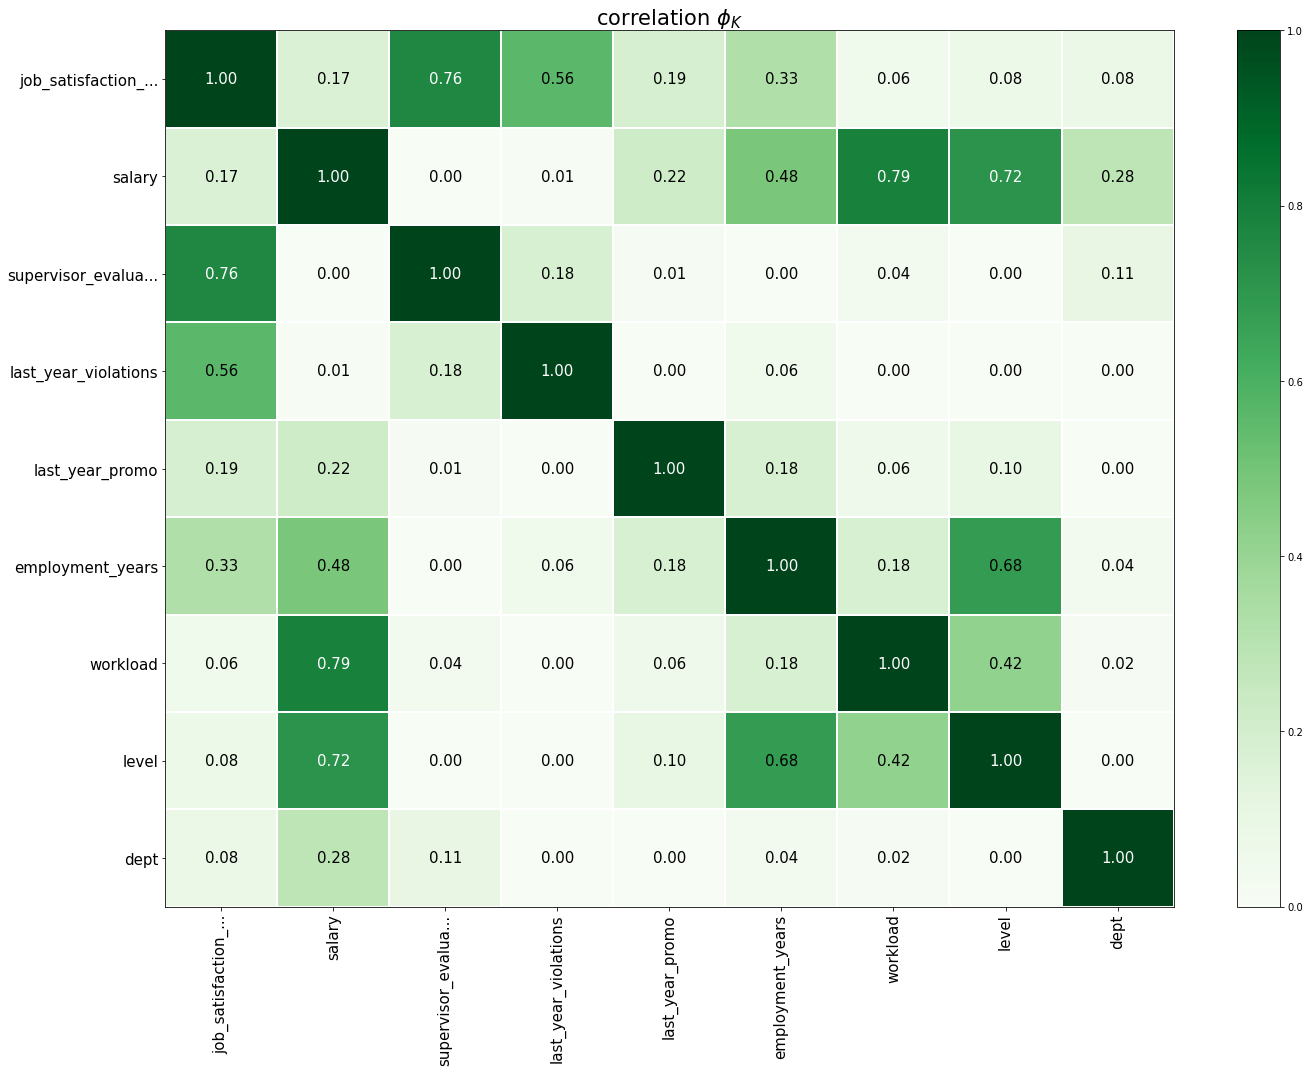

In [25]:
# Удаляем столбец 'id' из DataFrame
data_without_id = train_data.drop(columns=['id'])
    
# Рассчитываем матрицу корреляции методом, подходящим для ваших данных
phik_overview = data_without_id.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [26]:
quantitative_features = data_without_id.select_dtypes(include=['float64', 'int64'])

# Анализ мультиколлинеарности с использованием VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_data = calculate_vif(quantitative_features)
print(vif_data)

# Устранение мультиколлинеарности: 

if vif_data['VIF'].max() > 10:  # Обычный порог для высокого VIF
    feature_to_remove = vif_data.sort_values('VIF', ascending=False).iloc[0]['Feature']
    print(f"Удаление признака {feature_to_remove} из-за высокой мультиколлинеарности")
    quantitative_features = quantitative_features.drop(columns=[feature_to_remove])

# Повторный расчет VIF если необходимо

                 Feature        VIF
0       employment_years   4.186018
1  supervisor_evaluation  14.874757
2                 salary   6.493814
3  job_satisfaction_rate  13.656458
Удаление признака supervisor_evaluation из-за высокой мультиколлинеарности


В ходе исследовательского анализа не было выявлено аномальных значений или данных, требующих более детального расмотрения. Далее мы будем кодировать целевой признак и категориальные признаки, заполнять пропуски, масштабировать

## Шаг 4. Подготовка данных

In [27]:
# Константы
RANDOM_STATE = 42

# Загрузка тренировочных данных
X_train = train_data.drop(['job_satisfaction_rate', 'id'], axis=1)
y_train = train_data['job_satisfaction_rate']

# Загрузка тестовых данных

X_test = test_features
y_test = test_target['job_satisfaction_rate']

In [28]:
# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Кодирование целевого признака в тренировочной выборке
y_train_encoded = label_encoder.fit_transform(y_train)

# Кодирование целевого признака в тестовой выборке
y_test_encoded = label_encoder.transform(y_test)

# Теперь целевой признак закодирован в числовой формат
print("Sample из y_train_encoded:", y_train_encoded[:5])
print("Sample из y_test_encoded:", y_test_encoded[:5])

Sample из y_train_encoded: [84 77 70 68 57]
Sample из y_test_encoded: [32 54 45 73 76]


In [29]:
X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [30]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [31]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),    
    ('ord', OrdinalEncoder(categories=[
        ['junior', 'middle', 'sinior'],  # Категории для столбца "level"
        ['low', 'medium', 'high']  # Категории для столбца "workload"
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [32]:
# создаём общий пайплайн для подготовки данных
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

In [33]:
linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [34]:
# Определим функцию sMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Создаем скорер
smape_scorer = make_scorer(smape, greater_is_better=False)

param_grid = {
    'regressor__max_depth': [3, 5, 10, None],
    'regressor__min_samples_split': [2, 5, 10]
}

decision_tree_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Используем GridSearchCV с sMAPE
grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring=smape_scorer)

In [35]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [36]:
# Обучение линейной модели
linear_model = linear_model.fit(X_train, y_train)

In [37]:
# Оценка линейной модели с использованием кросс-валидации по метрике SMAPE
linear_model_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring=smape_scorer)

# Подбор гиперпараметров для дерева решений
grid_search.fit(X_train, y_train)
best_decision_tree_model = grid_search.best_estimator_

# Сравнение моделей по среднему значению метрики на кросс-валидации
mean_smape_linear = np.mean(linear_model_scores)
mean_smape_tree = grid_search.best_score_

print(f"Средний SMAPE для линейной модели: {mean_smape_linear}")
print(f"Лучший SMAPE для модели дерева решений: {mean_smape_tree}")

# Выбираем лучшую модель на основе метрики
if mean_smape_linear > mean_smape_tree:
    print("Линейная модель лучше на кросс-валидации")
else:
    print("Модель дерева решений лучше на кросс-валидации")

Средний SMAPE для линейной модели: -25.023292056149216
Лучший SMAPE для модели дерева решений: -14.839928330635
Модель дерева решений лучше на кросс-валидации


In [38]:
best_model = grid_search.best_estimator_

Мы провели кодирование и масштабирование данных, использовав две модели для машинного обучения - линейную и дерева решений. При помощи метрики SMAPE выяснили, что модель дерева решений работает лучше.

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [39]:
# загрузка файлов с указанием разделителя и десятичного знака

train_quit = pd.read_csv('/datasets/train_quit.csv', delimiter=',')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', delimiter=',')

In [40]:
# выводим первые 5 строк входных признаков тренировочной выборки
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [41]:
train_quit = train_quit.sort_values(by='id', ascending=False)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2120,999915,hr,middle,low,5,no,no,3,20400,no
18,999835,sales,junior,low,5,no,no,4,18000,no
3364,999158,purchasing,junior,medium,1,no,yes,1,21600,yes
3701,999003,hr,middle,low,3,no,no,2,24000,yes
2194,998517,purchasing,middle,low,5,no,no,3,19200,no


In [42]:
# выводим первые 5 строк входных признаков тестовой выборки
test_features = test_features.sort_values(by='id', ascending=False)

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1844,999029,technology,junior,medium,1,no,no,3,31200
1579,998900,marketing,middle,medium,7,no,no,3,45600
506,998762,technology,junior,low,3,no,no,3,22800
1886,998548,marketing,junior,medium,2,no,no,4,32400
1925,997290,sales,sinior,medium,7,no,no,4,58800


In [43]:
# выводим первые 5 строк целевого признака тестовой выборки
test_target_quit = test_target_quit.sort_values(by='id', ascending=False)

test_target_quit.head()

,id,quit
0,999029,yes
7,998900,no
731,998762,yes
116,998548,yes
1553,997290,no


Датасеты содержат строковые и численные значения. ID пользователей в test_features.csv и test_target_quit.csv совпадают


## Шаг 2. Предобработка данных

In [44]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2120 to 2600
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB


In [45]:
# Проверка основных статистик

train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [46]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [47]:
# Проверка основных статистик

test_target_quit.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


Аномальных значений и выбросов не обнаружено

## Шаг 3. Исследовательский анализ данных

In [48]:
# Делим данные на два датасета 

# Датасет с неуволившимися сотрудниками 

train_quit_no = train_quit[train_quit['quit'] == 'no']

train_quit_no.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2120,999915,hr,middle,low,5,no,no,3,20400,no
18,999835,sales,junior,low,5,no,no,4,18000,no
2194,998517,purchasing,middle,low,5,no,no,3,19200,no
3242,998324,sales,middle,medium,7,no,no,5,38400,no
1594,997917,sales,middle,low,5,no,no,5,28800,no


In [49]:
train_quit_no.describe()

,id,employment_years,supervisor_evaluation,salary
count,2872.000000,2872.000000,2872.000000,2872.000000
mean,555066.499652,4.430710,3.643106,37702.228412
std,260962.518935,2.544635,0.965295,15218.977339
min,100469.000000,1.000000,1.000000,12000.000000
25%,329560.500000,2.000000,3.000000,25200.000000
50%,548319.500000,4.000000,4.000000,34800.000000
75%,793533.500000,6.000000,4.000000,46800.000000
max,999915.000000,10.000000,5.000000,96000.000000


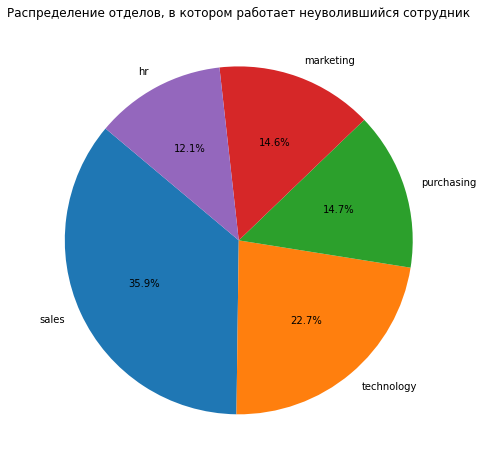

In [50]:
workload_counts = train_quit_no['dept'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(workload_counts, labels=workload_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение отделов, в котором работает неуволившийся сотрудник')
plt.show()

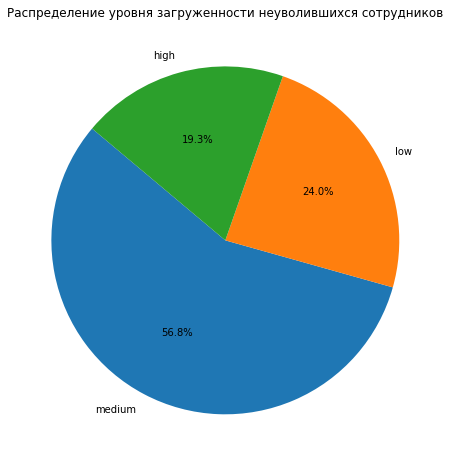

In [51]:
workload_counts = train_quit_no['workload'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(workload_counts, labels=workload_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение уровня загруженности неуволившихся сотрудников')
plt.show()

In [52]:
# Датасет с уволившимися сотрудниками 

train_quit_yes = train_quit[train_quit['quit'] == 'yes']

train_quit_yes.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3364,999158,purchasing,junior,medium,1,no,yes,1,21600,yes
3701,999003,hr,middle,low,3,no,no,2,24000,yes
3426,997272,hr,junior,medium,1,no,no,1,25200,yes
841,996445,sales,junior,low,2,no,no,1,12000,yes
2737,994739,hr,junior,medium,1,no,yes,3,25200,yes


In [53]:
train_quit_yes.describe()

,id,employment_years,supervisor_evaluation,salary
count,1128.000000,1128.000000,1128.000000,1128.000000
mean,544544.457447,1.844858,3.046099,23885.106383
std,258059.498361,1.274920,0.973291,9351.599505
min,100222.000000,1.000000,1.000000,12000.000000
25%,325073.000000,1.000000,3.000000,16800.000000
50%,545003.500000,1.000000,3.000000,22800.000000
75%,756296.000000,2.000000,4.000000,27600.000000
max,999158.000000,10.000000,5.000000,79200.000000


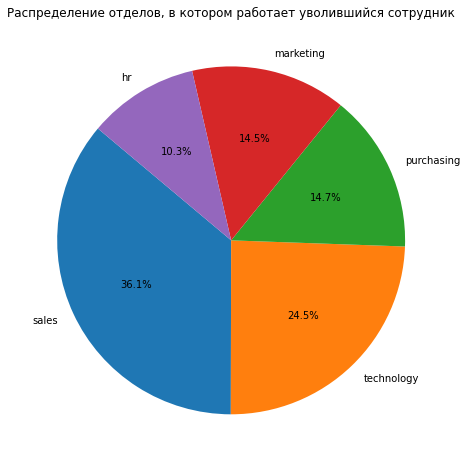

In [54]:
workload_counts = train_quit_yes['dept'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(workload_counts, labels=workload_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение отделов, в котором работает уволившийся сотрудник')
plt.show()

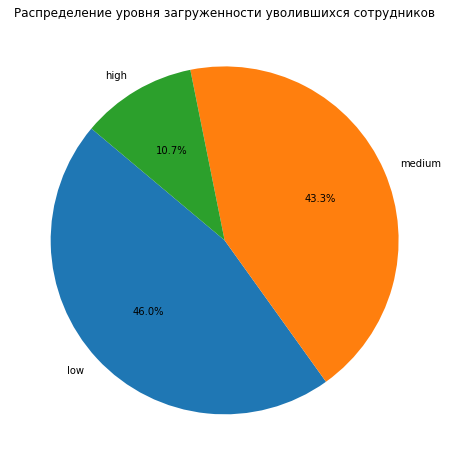

In [55]:
workload_counts = train_quit_yes['workload'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(workload_counts, labels=workload_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение уровня загруженности уволившихся сотрудников')
plt.show()

Мы видим, что среди уволившихся сотрудников большой процент имеет маленькую загрузку. Сотрудники же, которые имеют высокую назгрузку увольняются реже. Также у уволившихся сотрудников ниже оплата труда. Доля отделов среди уволившихся и не уволившихся сотрудников одинакова

In [56]:
# Затем объединяем результат с test_target_quit по'id'
merged_df = pd.merge(test_target, test_target_quit, on='id')

merged_df.head()

,id,job_satisfaction_rate,quit
0,999029,0.35,yes
1,998900,0.57,no
2,998762,0.48,yes
3,998548,0.76,yes
4,997290,0.79,no


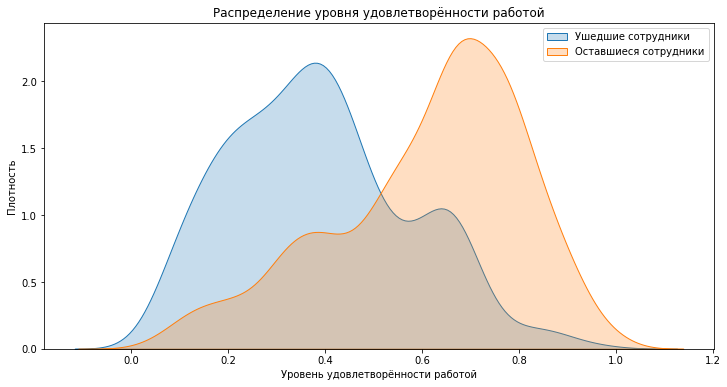

In [57]:
# Разделение данных на ушедших и оставшихся сотрудников

quit_employees = merged_df[merged_df['quit'] == 'yes']
stayed_employees = merged_df[merged_df['quit'] == 'no']

# Визуализация распределения уровня удовлетворённости работой

plt.figure(figsize=(12, 6))

# График для ушедших сотрудников

sns.kdeplot(quit_employees['job_satisfaction_rate'], label='Ушедшие сотрудники', shade=True)

# График для оставшихся сотрудников

sns.kdeplot(stayed_employees['job_satisfaction_rate'], label='Оставшиеся сотрудники', shade=True)

plt.title('Распределение уровня удовлетворённости работой')
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность')
plt.legend()
plt.show()

у ушедших сотрудников уровень удовлетворенности работой ниже

## Шаг 4. Добавление нового входного признака

In [58]:
# Добавление job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

test_features['job_satisfaction_rate'] = best_model.predict(test_features)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
# Выводим первые 5 строк получившегося датасета

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1844,999029,technology,junior,medium,1,no,no,3,31200,0.312222
1579,998900,marketing,middle,medium,7,no,no,3,45600,0.464286
506,998762,technology,junior,low,3,no,no,3,22800,0.496667
1886,998548,marketing,junior,medium,2,no,no,4,32400,0.793333
1925,997290,sales,sinior,medium,7,no,no,4,58800,0.821250


## Шаг 5. Подготовка данных

In [60]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25


# Загрузка тренировочных данных
X_train = train_quit.drop(['quit', 'id'], axis=1)
y_train = train_quit['quit']


# Загрузка тестовых данных

X_test = test_features
y_test = test_target_quit['quit'] 


# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Кодирование целевого признака в тренировочной выборке
y_train_encoded = label_encoder.fit_transform(y_train)

# Кодирование целевого признака в тестовой выборке
y_test_encoded = label_encoder.transform(y_test)

# Теперь целевой признак закодирован в числовой формат
print("Sample из y_train_encoded:", y_train_encoded[:5])
print("Sample из y_test_encoded:", y_test_encoded[:5])

X_train.shape, X_test.shape


# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),    
    ('ord', OrdinalEncoder(categories=[
        ['junior', 'middle', 'sinior'],  # Категории для столбца "level"
        ['low', 'medium', 'high']  # Категории для столбца "workload"
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# создаём общий пайплайн для подготовки данных
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])

Sample из y_train_encoded: [0 0 1 1 0]
Sample из y_test_encoded: [1 0 1 1 0]


In [61]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],  # Установка probability=True
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 

    },    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [62]:
print(X_train.columns)

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary'],
      dtype='object')


In [63]:
# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Обучение модели с помощью GridSearch
try:
    grid_search.fit(X_train, y_train_encoded)
    
    # Вывод результатов
    print('**Лучшая модель и её параметры:**\n\n', grid_search.best_estimator_)
    print('**Метрика лучшей модели (ROC AUC) на тренировочной выборке:**', grid_search.best_score_)
    
    # Проверка работы модели на тестовой выборке и прогноз
    y_test_pred = grid_search.predict_proba(X_test)[:, 1]
    print(f'**Метрика ROC-AUC на тестовой выборке:** {roc_auc_score(y_test_encoded, y_test_pred)}')
    
except ValueError as e:
    print(e)

**Лучшая модель и её параметры:**

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                               

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  
    1. Общая структура модели: 
   - В процессе создания модели был использован конвейер Pipeline, состоящий из двух основных шагов: предобработки данных и применения модели SVC. Такой подход позволяет обеспечить последовательность и автоматизацию всех этапов подготовки и обучения.

2. Предобработка данных: 
   - ColumnTransformer был использован для раздельной обработки категориальных и числовых признаков.
   - Категориальные признаки были обработаны с применением:
     - OneHotEncoder для одномерного кодирования категорий, что уменьшает мультиколлинеарность.
     - OrdinalEncoder для упорядоченных категорий, таких как 'уровень' сотрудника и 'нагрузка'.
   - Пробелы в данных были заполнены с помощью SimpleImputer:
     - Для категориальных данных использовалась заполнение наиболее частым значением.
   - Числовые признаки нормализованы с применением StandardScaler, что способствует лучшей работе моделей, чувствительных к масштабу данных.

3. Модель классификации:
   - Для классификации использована модель Support Vector Classifier (SVC) с вероятностной оценкой классов и фиксированным random_state=42 для воспроизводимости результатов.
   - Преимущества использования SVC: хорошо работает в ситуациях, где границы классов не линейны и даёт хорошую обобщающую способность на разнообразных наборах данных.

4. Результаты метрик:
   - На тренировочной выборке модель достигла показателя ROC AUC = 0.9227. 
   - На тестовой выборке ROC AUC составил 0.9213.
   - После анализа данных можно сказать, что модель проявляет стабильные результаты как на тренировочной, так и на тестовой выборке, что указывает на хорошую обобщающую способность модели и отсутствие переобучения.

Модель демонстрирует хорошие результаты, и проделанная работа в части предобработки данных явно способствует созданию модели с высокой обобщающей способностью

В ходе исследования мы построили модели, предсказывающие уровень удовлетворенности работой и вероятность увольнения сотрудника. Проанализировали взаимосвязь этих параметров, а также составили портрет уволившихся сотрудников: как правило, это сотрудник с низкой загруженностью и зарплатой, а также с низким уровнем удовлетворенности работой.

В первой задаче уровень удовлетворенности работой лучше всего предсказывыает модель дерева решений. Во второй задаче лучше всего справилась модель SVC.

Использование модели позволит предсказать возможность увольнения сотрудника и предпринять меры профилактики, что сможет привести к снижению оттока сотрудников